In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform

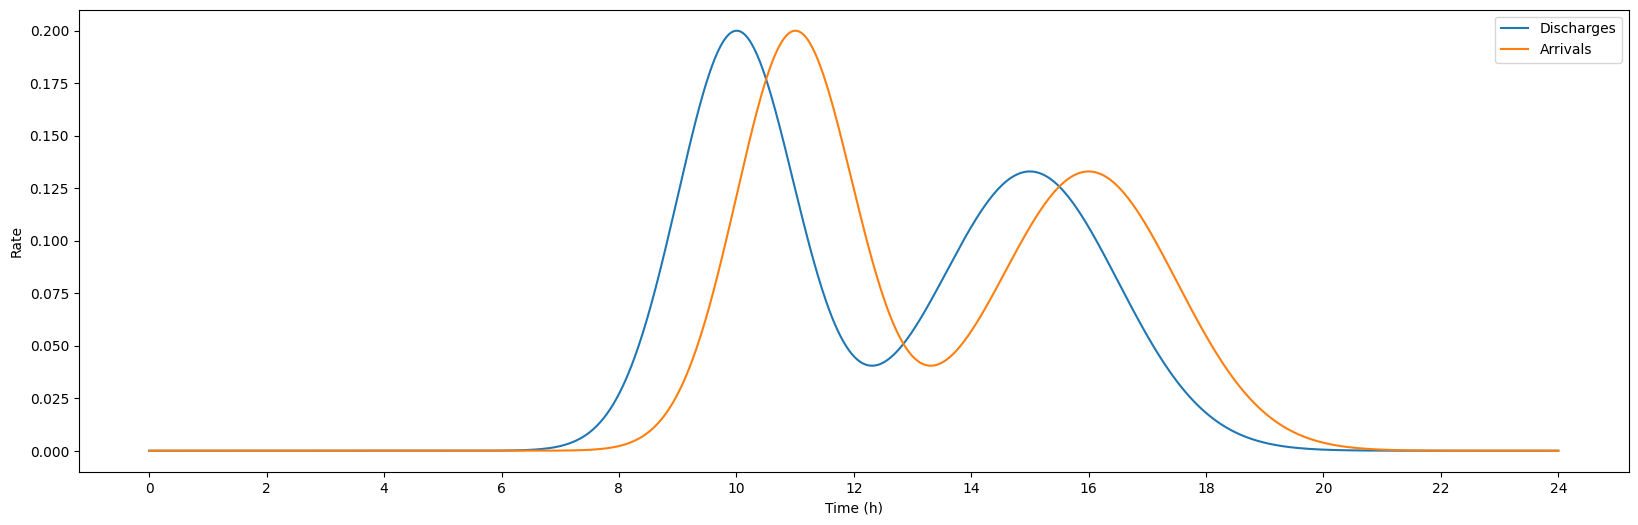

In [4]:
p_ = 0.55
t_ = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t_, discharge_dist.pdf(t_), label="Discharges")
ax.plot(t_, admission_dist.pdf(t_), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

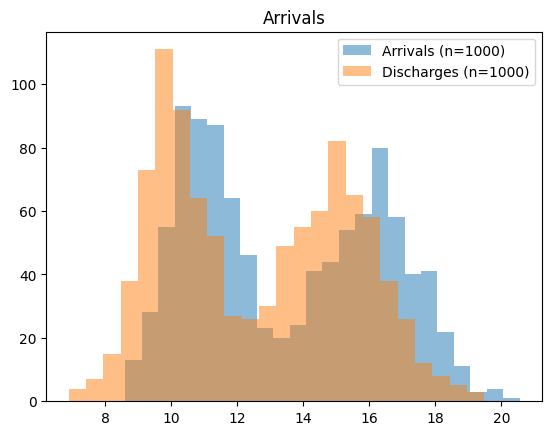

In [5]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

In [6]:
from heapq import heapify, heappop, heappush
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm import tqdm

## Timeline of a bed
All the while the bed may have to wait for available transport and washing. 
- Patient is admitted to the hospital and occupies a bed.
- Patient is discharged, and the bed is sent to the logistics floor.
- Bed is transported from the elevator to the washing area.
- Bed is washed.
- Bed is transported back to the elevator.

In [7]:
@dataclass
class Event:
    time: float

    def __lt__(self, other):
        return self.time < other.time

@dataclass
class BedLeaveElevator(Event):
    pass

@dataclass
class BedArrivedWashing(Event):
    pass

@dataclass
class BedFinishedWashing(Event):
    pass

@dataclass
class BedArriveElevator(Event):
    pass


In [8]:
def plot_queue_length(results):
    plt.figure(figsize=(12, 6))
    plt.title('Queue Length Over Time in Blocking System')
    # for run in results:
    plt.plot(results[1], results[2], label='Queue Length')
    
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.show()



## Current assumptions
- Bot teleports when not pushing bed
- Transportation time only occurs over the 175m distance in logistic room, e.g. not elevator to dirty buffer
- Elevator can transport beds at any time, bot up and down simultaneously.


## Issues
- What happens if two beds come immediately after each other? 
    - The bot should be occupied with the first bed until it is done, so the second bed should wait.

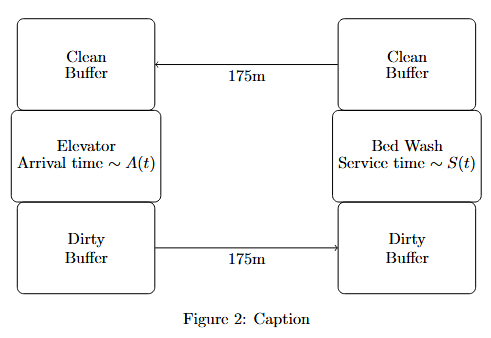

Absolute cancer for there to be duplicates of buffer. For now assume dirty buffer is 

0


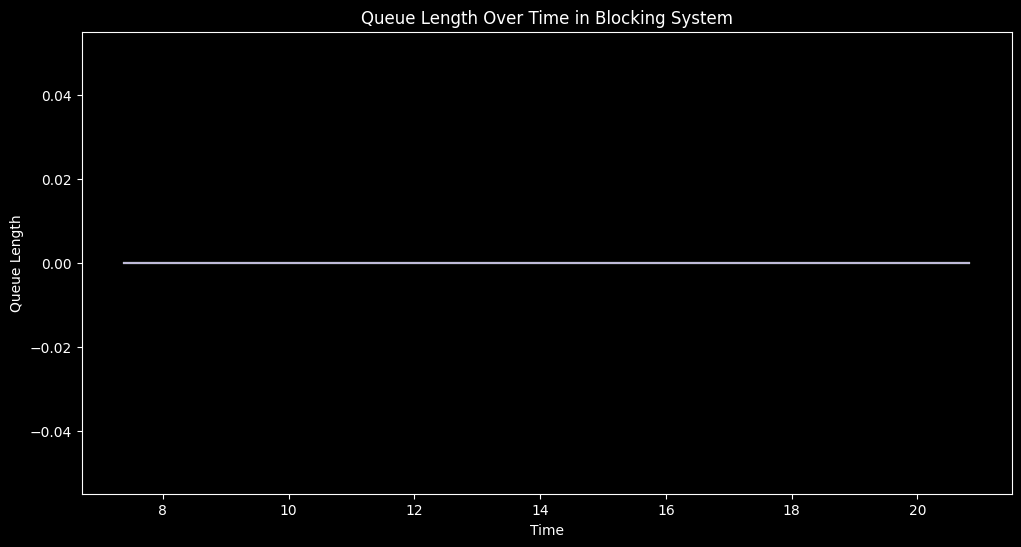

[BedLeaveElevator(time=7.380254895910255),
 BedArrivedWashing(time=7.39196425586434),
 BedFinishedWashing(time=7.400297589220192),
 BedArriveElevator(time=7.4045121528923),
 BedLeaveElevator(time=8.012431085399108),
 BedArrivedWashing(time=8.017579633625937),
 BedFinishedWashing(time=8.02591296712778),
 BedArriveElevator(time=8.03105573025045),
 BedLeaveElevator(time=8.040329876120225),
 BedArrivedWashing(time=8.051560958022522),
 BedFinishedWashing(time=8.059894291400301),
 BedLeaveElevator(time=8.086719755342202),
 BedArriveElevator(time=8.088981632720088),
 BedLeaveElevator(time=8.392516765438772),
 BedArrivedWashing(time=8.39814806558533),
 BedFinishedWashing(time=8.406481399088271),
 BedArriveElevator(time=8.394433487069826),
 BedArrivedWashing(time=8.415957568295278),
 BedFinishedWashing(time=8.424290901690728),
 BedArriveElevator(time=8.422543371914887),
 BedLeaveElevator(time=8.449336568933868),
 BedArrivedWashing(time=8.468185832673917),
 BedFinishedWashing(time=8.476519166077

In [36]:
class ButtManager:
    def __init__(self, num_bots: int, transport_time_dist : callable):
        self.bots_available = num_bots
        self.transport_time_dist = transport_time_dist
    
    def update(self, events, t, state):
        event_type = self.decision_policy(state) 
        if event_type is not None:
            heappush(events, event_type(t + self.transport_time_dist()))
    
    def decision_policy(self, state):
        # Favor returning clean bed over starting washing
        if self.bots_available == 0:
            return None
        
        self.bots_available -= 1
        if state[2] > 0:
            state[2] -= 1
            return BedArriveElevator
        if state[0] > 0:
            state[0] -= 1
            return BedArrivedWashing
        
        return None  # No action if no beds are available to process
        
    def release_bot(self):
        self.bots_available += 1


def simulate_system(
        discharge_dist : callable,
        service_time_dist : callable,
        transport_time_dist : callable,
        n_patients: int = 200
    ):

    state = [0] * 3  # [waiting for bot -> washing, waiting for washing, waiting for bot -> elevator]
    butt_manager = ButtManager(1, transport_time_dist)

    discharge_times = discharge_dist.rvs(size=n_patients)

    events = [BedLeaveElevator(time) for time in discharge_times]
    heapify(events)

    events_processed = []
    states = []
    times = []

    washer_ready = True

    iterations = 0
    while events:
        iterations += 1
        if iterations > 10000:
            break
        event = heappop(events)

        match event:
            case BedLeaveElevator(time=t):
                state[0] += 1
                butt_manager.update(events, t, state)
                
            case BedArrivedWashing(time=t):
                state[1] += 1
                butt_manager.release_bot()
                
                # If washer ready, start washing immediately 
                if washer_ready:
                    washer_ready = False
                    state[1] -= 1
                    heappush(events, BedFinishedWashing(t + service_time_dist()))
                
                butt_manager.update(events, t, state)
                    
            case BedFinishedWashing(time=t):
                washer_ready = True
                state[2] += 1
                butt_manager.release_bot()

                # If washer is ready and there are beds waiting outside
                if state[1] > 0:
                    washer_ready = False
                    state[1] -= 1
                    heappush(events, BedFinishedWashing(t + service_time_dist()))
                
                butt_manager.update(events, t, state)
            
            case BedArriveElevator(time=t):
                butt_manager.release_bot()
        
        states.append(state)
        times.append(event.time)
            

        events_processed.append(event)

    return events_processed, np.array(times), np.array(states, dtype=int)

np.random.seed(42)
service_min_time = 1/120  # 10 minute
service_time_dist = lambda: service_min_time + expon(scale=1e-10).rvs()
transport_time_dist = lambda: norm(loc=1/120, scale=1e-2).rvs()  # 1/2 minute to transport a bed

results = simulate_system(discharge_dist, service_time_dist, transport_time_dist, n_patients=200)
print(f"{np.max(results[2])}")  
plot_queue_length(results)
results[0]

# Looking at distributions

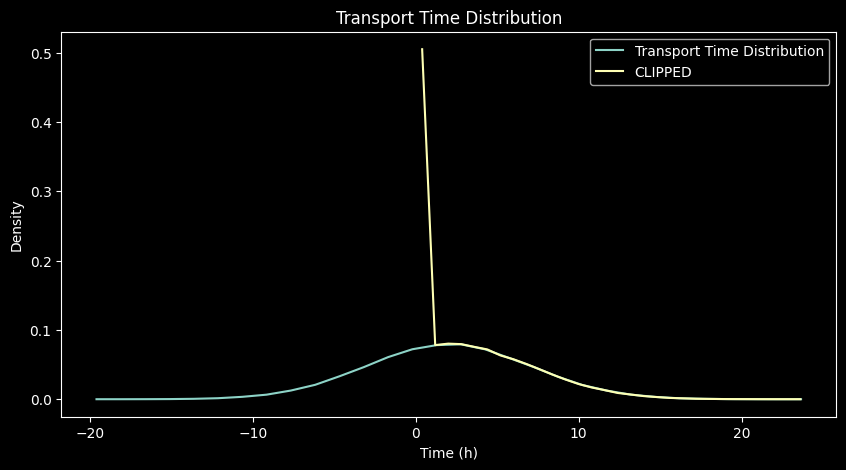

In [222]:
# plot transport_time_dist
def plot_transport_time_dist():
    # sample 100 samples
    samples = norm(loc=2, scale=5).rvs(size=113000)
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    # Center the bins for plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    samples = np.clip(samples, 0, 24)  # Clip to 24 hours
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.plot(t, y, label="CLIPPED")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist()

124.00000000000001
124.10722756451115 133.38903130519842 125.13387827965883


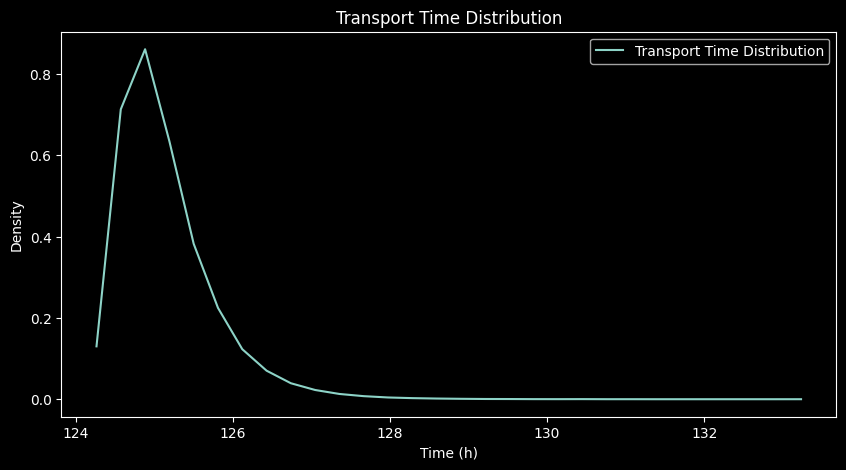

In [264]:
from scipy.stats import lognorm
def plot_transport_time_dist():
    # 175 [m] / 1.4 [m/s]
    loc = (175 / 1.4 - 1)
    print(loc)
    # sample 100 samples
    samples = lognorm(loc=loc, s=.5).rvs(size=100000)# / 60 / 60
    print(np.min(samples), np.max(samples), np.mean(samples))
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist() # 125.13387827965883

1.0000364749224109 5.479084251025757 1.7987631225633336


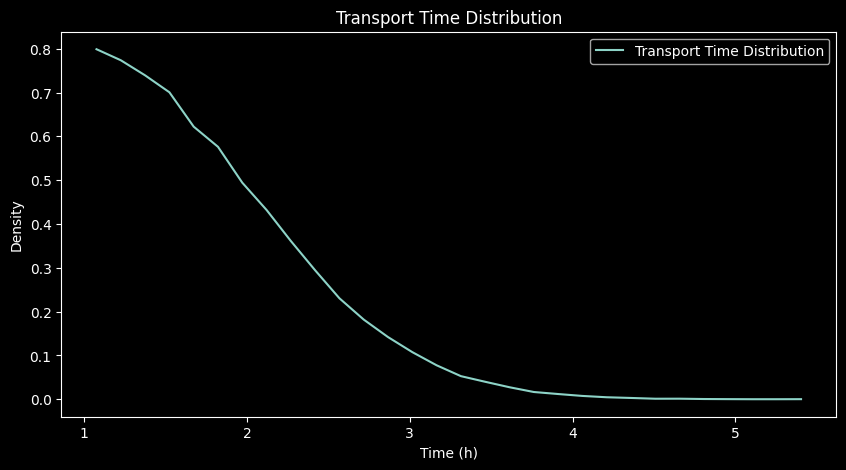

In [247]:
from scipy.stats import halfnorm
def plot_transport_time_dist():
    # sample 100 samples
    samples = halfnorm(loc=1, scale=1).rvs(size=100000)
    print(np.min(samples), np.max(samples), np.mean(samples))
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist()